# Chapter 9 - Working with geospatial data

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geodatasets import get_path

## Create a GeoDataFrame from a DataFrame

### From longitude/latitude

In [2]:
df = pd.DataFrame(
    {
        "City": ["New York", "Washington DC", "Boston"],
        "Latitude": [40.42, 38.53, 42.21],
        "Longitude": [-74, -77.02, -71.03],
    }
)

A GeoDataFrame is a DataFrame that has a column `geometry` containing shapely object like Point, Polygon or MultiPolygon. We use geopandas method `points_from_xy()` to transform Longitude and Latitude into a list of shapely.Point objects and set it as a `geometry`column. The crs value is also set to explicitly state the geometry data defines latitude/ longitude world geodetic degree values.

The GeoDataFrame is constructed as follows :

In [3]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326"
)

`gdf` looks like this :

In [4]:
gdf.head()

,City,Latitude,Longitude,geometry
0,New York,40.42,-74.00,POINT (-74 40.42)
1,Washington DC,38.53,-77.02,POINT (-77.02 38.53)
2,Boston,42.21,-71.03,POINT (-71.03 42.21)


We can plot the GeoDataFrame

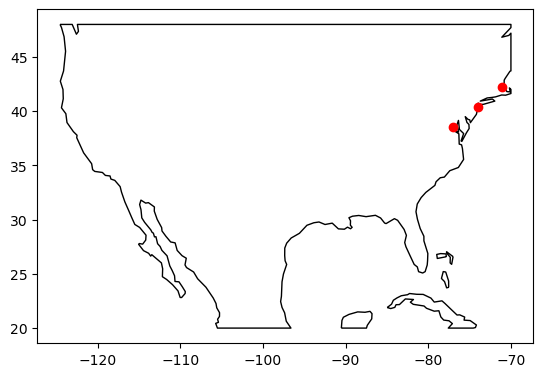

In [5]:
world = gpd.read_file(get_path("naturalearth.land"))

# We restrict to USA.
ax = world.clip([-130, 20, -70, 48]).plot(color="white", edgecolor="black")

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color="red")

plt.show()

### From point coordinates (WTK format)

In [6]:
df = pd.DataFrame(
    {
        "City": ["New York", "Washington DC", "Boston"],
        "Coordinates":["POINT(-74 40.42)","POINT(-77.02 38.53)","POINT(-71.03 42.21)"],
    }
)

We use `shapely.wkt` sub-module to parse wkt format:

In [7]:
from shapely import wkt

df["Coordinates"] = gpd.GeoSeries.from_wkt(df["Coordinates"])

The GeoDataFrame is constructed as follows :

In [8]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,City,Coordinates
0,New York,POINT (-74 40.42)
1,Washington DC,POINT (-77.02 38.53)
2,Boston,POINT (-71.03 42.21)


We can plot the GeoDataFrame

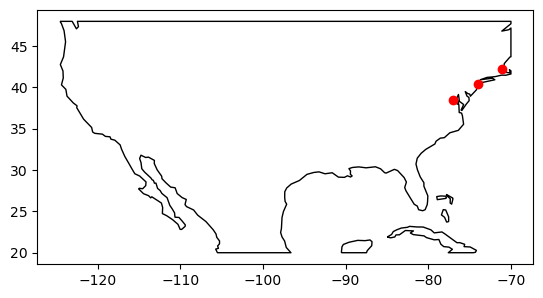

In [9]:
world = gpd.read_file(get_path("naturalearth.land"))

# We restrict to USA.
ax = world.clip([-130, 20, -70, 48]).plot(color="white", edgecolor="black")

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color="red")

plt.show()

## Create a GeoDataFrame and plot it 

Create a GeoDataFrame from a file using the method `read_file`

In [10]:
gdf = gpd.read_file(get_path("ny.bb"))

In [11]:
gdf

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


Such a GeoDataFrame is just like a pandas DataFrame, but with some additional functionality for working with geospatial data.  

A .geometry attribute that always returns the column with the geometry information (returning a GeoSeries). The column name itself does not necessarily need to be 'geometry', but it will always be accessible as the .geometry attribute.
It has some extra methods for working with spatial data (area, distance, buffer, intersection, ...), which we will learn in later notebooks


A GeoDataFrame can be plotted

<Axes: >

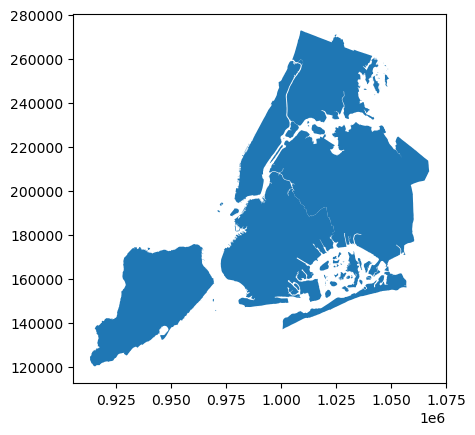

In [12]:
gdf.plot()

Plot each borough in a different color

<Axes: >

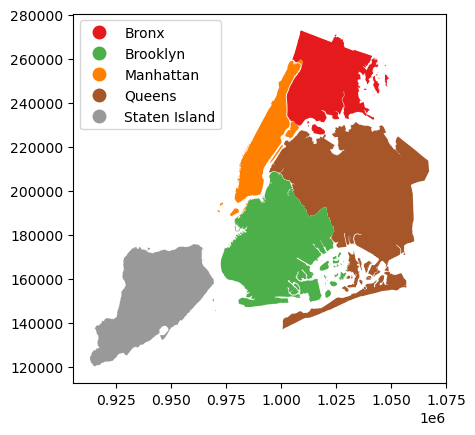

In [13]:
gdf.plot(column=gdf["BoroName"],cmap="Set1",legend=True,legend_kwds={'loc': 'upper left'})

Plot according to the area

<Axes: >

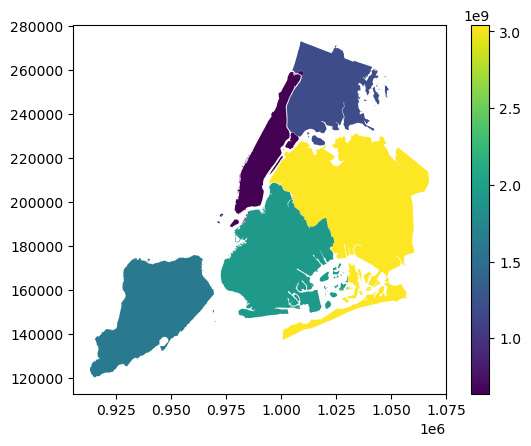

In [14]:
gdf.plot("Shape_Area", legend=True)

## Handle region of interest (ROI)

Geopandas allow you to compare two GeoDataFrames containing polygon or multipolygon geometries and create a new GeoDataFrame with the new geometries representing the spatial combination and merged properties. This can be done with `geopandas.tool.overlay`.
The basic idea is demonstrated by the graphic below but keep in mind that overlays operate at the dataframe level, not on individual geometries, and the properties from both are retained  

![Overlays](../images/overlays.png)  
from geopandas' documentation

Let's define two ROI

In [15]:
from shapely import Polygon

In [16]:
roi1 = Polygon(((1000000,180000),(1025000,180000),(1025000,200000),(1000000,200000),(1000000,180000)))
roi2 = Polygon(((1010000,190000),(1035000,190000),(1035000,240000),(1010000,240000),(1010000,190000)))

In [17]:
rois = gpd.GeoDataFrame(data={"ID": [1, 2],"color":["blue","red"]}, geometry=[roi1,roi2], crs=gdf.crs)

In [18]:
rois

,ID,color,geometry
0,1,blue,"POLYGON ((1000000 180000, 1025000 180000, 1025..."
1,2,red,"POLYGON ((1010000 190000, 1035000 190000, 1035..."


Plot `gdf` and the two ROI

<Axes: >

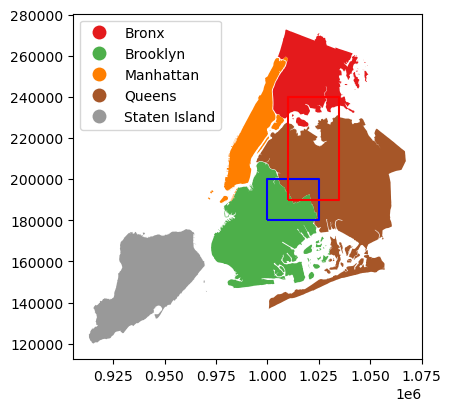

In [19]:
_, ax = plt.subplots(1, figsize=(4.5,10))
gdf.plot(ax=ax, column=gdf["BoroName"],cmap="Set1",legend=True,legend_kwds={'loc': 'upper left'})
rois.boundary.plot(ax=ax,color=rois["color"])

### Extract data corresponding to the ROI union

<Axes: >

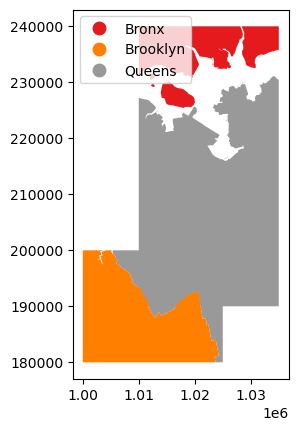

In [20]:
newgdf = gdf.overlay(rois, how="intersection")
newgdf.plot(column=newgdf["BoroName"],cmap="Set1",legend=True,legend_kwds={'loc': 'upper left'})

### Extract data corresponding to a ROI

Extract data from `gdf` that correspond to ROI2

<Axes: >

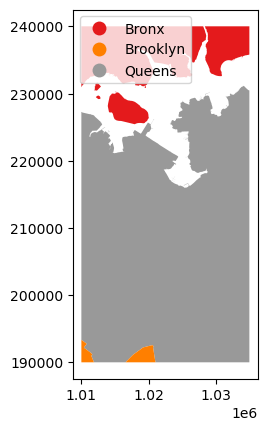

In [21]:
newgdf = gdf.overlay(rois[rois["ID"] == 2], how="intersection")
newgdf.plot(column=newgdf["BoroName"],cmap="Set1",legend=True,legend_kwds={'loc': 'upper left'})

### Extract data outside the ROI union

<Axes: >

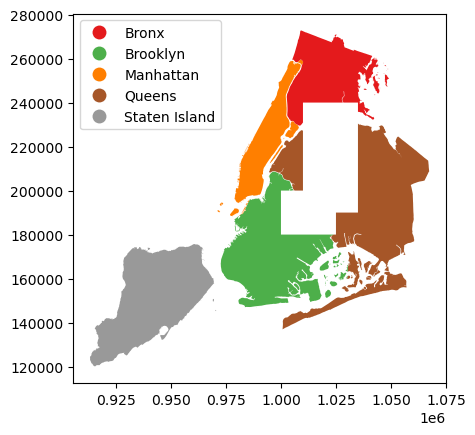

In [22]:
newgdf = gdf.overlay(rois, how="difference")
newgdf.plot(column=newgdf["BoroName"],cmap="Set1",legend=True,legend_kwds={'loc': 'upper left'})

## Processing

Extract data from `gdf` that correspond to ROI2 and compute the area (using `area`). Then, plot the data.

<Axes: >

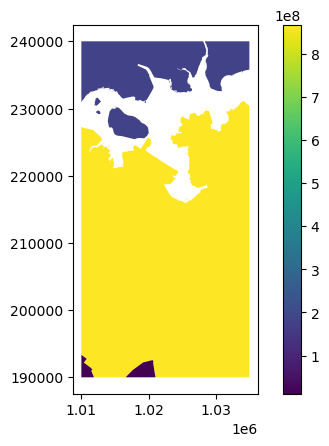

In [23]:
newgdf = gdf.overlay(rois[rois["ID"] == 2], how="intersection")
newgdf["roi_area"] = newgdf.area
newgdf.plot("roi_area", legend=True)